<a href="https://colab.research.google.com/github/Average-Me/weather-temperature-forecast-finland/blob/lag%2Broll/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/projectx/trim_data.csv'

df = pd.read_csv(file_path)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,year,month,day,hour,day_of_week,Temperature (C)
0,2006,3,31,22,4,9.472222
1,2006,3,31,23,4,9.355556
2,2006,4,1,0,5,9.377778
3,2006,4,1,1,5,8.288889
4,2006,4,1,2,5,8.755556
...,...,...,...,...,...,...
96448,2016,9,9,17,4,26.016667
96449,2016,9,9,18,4,24.583333
96450,2016,9,9,19,4,22.038889
96451,2016,9,9,20,4,21.522222


In [17]:
#добавляем lag
df2 = df.copy()
df2['Lag'] = df2['Temperature (C)'].diff(periods = 1)
df2['Rol'] = df2['Temperature (C)'].rolling(window = 3).mean()
df2

,year,month,day,hour,day_of_week,Temperature (C),Lag,Rol
0,2006,3,31,22,4,9.472222,NaN,NaN
1,2006,3,31,23,4,9.355556,-0.116667,NaN
2,2006,4,1,0,5,9.377778,0.022222,9.401852
3,2006,4,1,1,5,8.288889,-1.088889,9.007407
4,2006,4,1,2,5,8.755556,0.466667,8.807407
...,...,...,...,...,...,...,...,...
96448,2016,9,9,17,4,26.016667,-2.822222,28.540741
96449,2016,9,9,18,4,24.583333,-1.433333,26.479630
96450,2016,9,9,19,4,22.038889,-2.544444,24.212963
96451,2016,9,9,20,4,21.522222,-0.516667,22.714815


In [18]:
#добавляем lag, слишком долго считает(30с)

# df2['Lag'] = None
# for i in range(1,len(df2)):
#   df2.loc[ i, 'Lag'] = df2['Temperature (C)'][i]-df2['Temperature (C)'][i-1]
# print(len(df2))
# df2

In [19]:
features = ['year', 'month', 'day', 'hour', 'day_of_week','Lag','Rol' ]
X = df2[features]
y = df2['Temperature (C)']

print("Признаки для обучения:")
print(X.head())
print(f"Размер X: {X.shape}")

Признаки для обучения:
   year  month  day  hour  day_of_week       Lag       Rol
0  2006      3   31    22            4       NaN       NaN
1  2006      3   31    23            4 -0.116667       NaN
2  2006      4    1     0            5  0.022222  9.401852
3  2006      4    1     1            5 -1.088889  9.007407
4  2006      4    1     2            5  0.466667  8.807407
Размер X: (96453, 7)


In [20]:
train_size = int(len(df2)*0.8)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]
print(len(X_train))
print(len(X_test))

77162
19291


In [21]:
model = RandomForestRegressor(
    n_estimators = 50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
print("Обучение модели")
model.fit(X_train, y_train)

# Предсказания
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Обучение модели


In [26]:
#Считаем ошибку
#Mean Absolute Error (Средняя абсолютная ошибка)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

#Root Mean Squared Error (Корень из средней квадратичной ошибки)
train_rmse = mean_squared_error(y_train, y_pred_train)
test_rmse = mean_squared_error(y_test, y_pred_test)

#Коэффициент детерминации (Explained Variance)
r2 = r2_score(y_test, y_pred_test)

print("РЕЗУЛЬТАТЫ")
print(f"train_MAE: {train_mae:.2f}°C")
print(f"test_MAE:  {test_mae:.2f}°C")
print()
print(f"train_RMSE: {train_rmse:.2f}°C")
print(f"test_RMSE:  {test_rmse:.2f}°C")
print()
print(f"R2: {train_rmse:.2f}")
print(f"R2: {test_rmse:.2f}")

РЕЗУЛЬТАТЫ
train_MAE: 0.25°C
test_MAE:  0.23°C

train_RMSE: 0.17°C
test_RMSE:  0.14°C

R2: 0.17
R2: 0.14


In [23]:
importance = pd.DataFrame({
    'Признак': features,
    'Важность': model.feature_importances_
}).sort_values('Важность', ascending=False)
print(importance)

       Признак  Важность
6          Rol  0.983563
5          Lag  0.015965
3         hour  0.000385
2          day  0.000048
0         year  0.000014
1        month  0.000013
4  day_of_week  0.000012


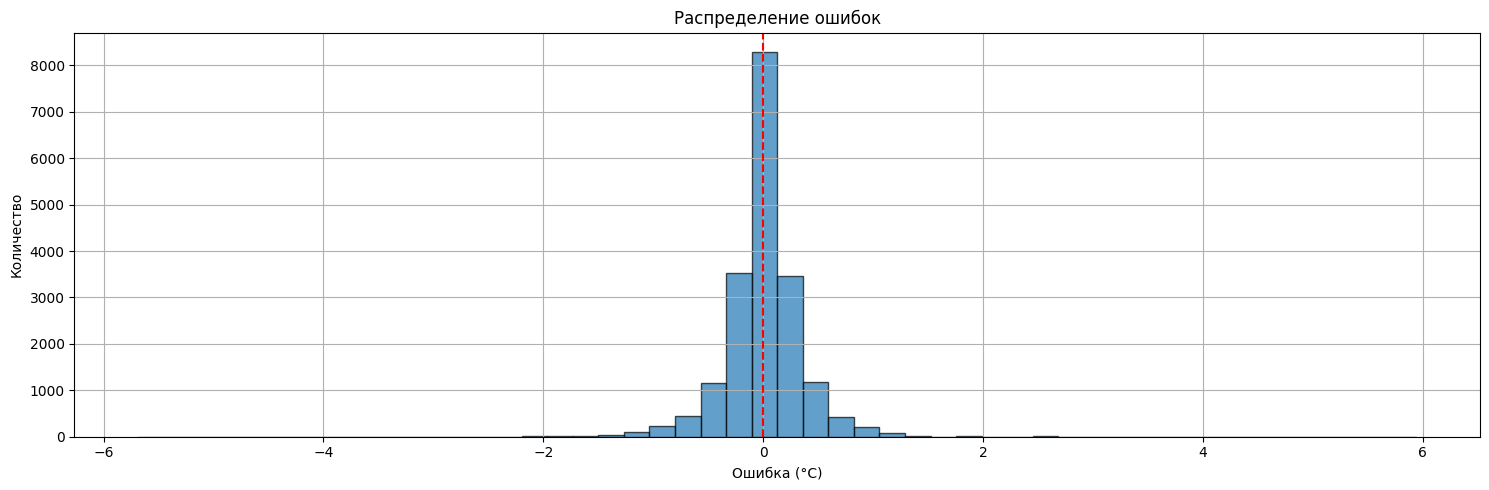

In [24]:
#Сравнение реальных и предсказанных значений
fig, axes = plt.subplots(figsize=(15, 5))

# Распределение ошибок
errors = y_test - y_pred_test
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Ошибка (°C)')
plt.ylabel('Количество')
plt.title('Распределение ошибок')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

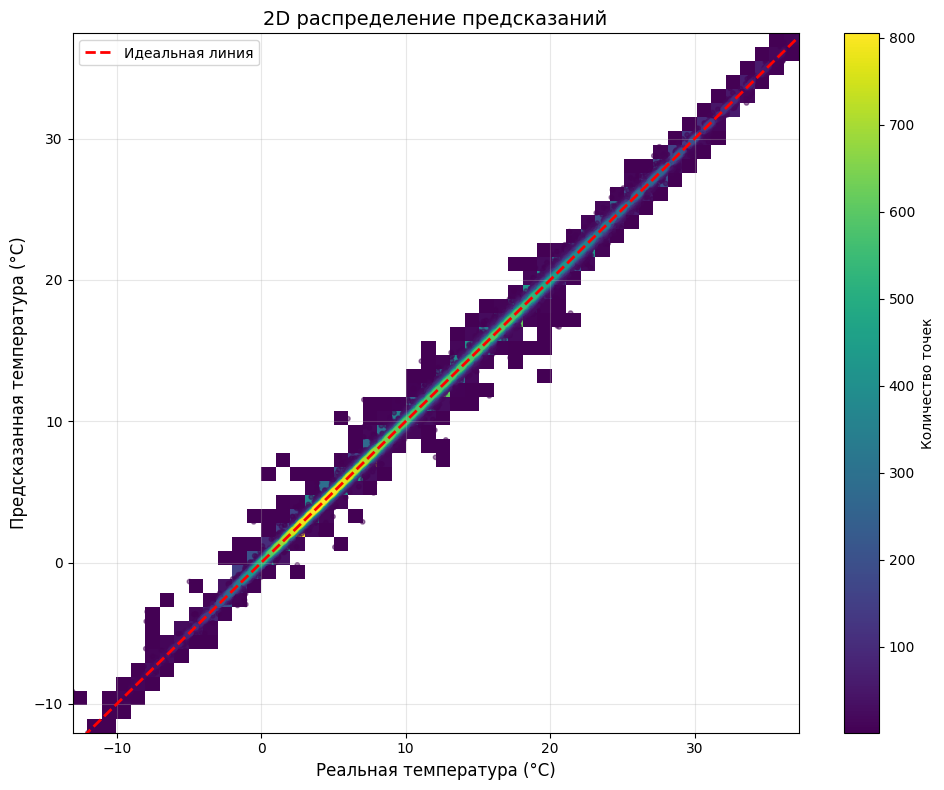

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

h = ax.hist2d(y_test, y_pred_test, bins=50, cmap='viridis', cmin=1)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'r--', lw=2, label='Идеальная линия')


from scipy.stats import gaussian_kde
xy = np.vstack([y_test, y_pred_test])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
ax.scatter(y_test.iloc[idx], y_pred_test[idx],
           c=z[idx], s=10, cmap='viridis', alpha=0.5)

ax.set_xlabel('Реальная температура (°C)', fontsize=12)
ax.set_ylabel('Предсказанная температура (°C)', fontsize=12)
ax.set_title('2D распределение предсказаний', fontsize=14)
plt.colorbar(h[3], ax=ax, label='Количество точек')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()